In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

import numpy as np
import os

import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 9033 files belonging to 6 classes.


In [7]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

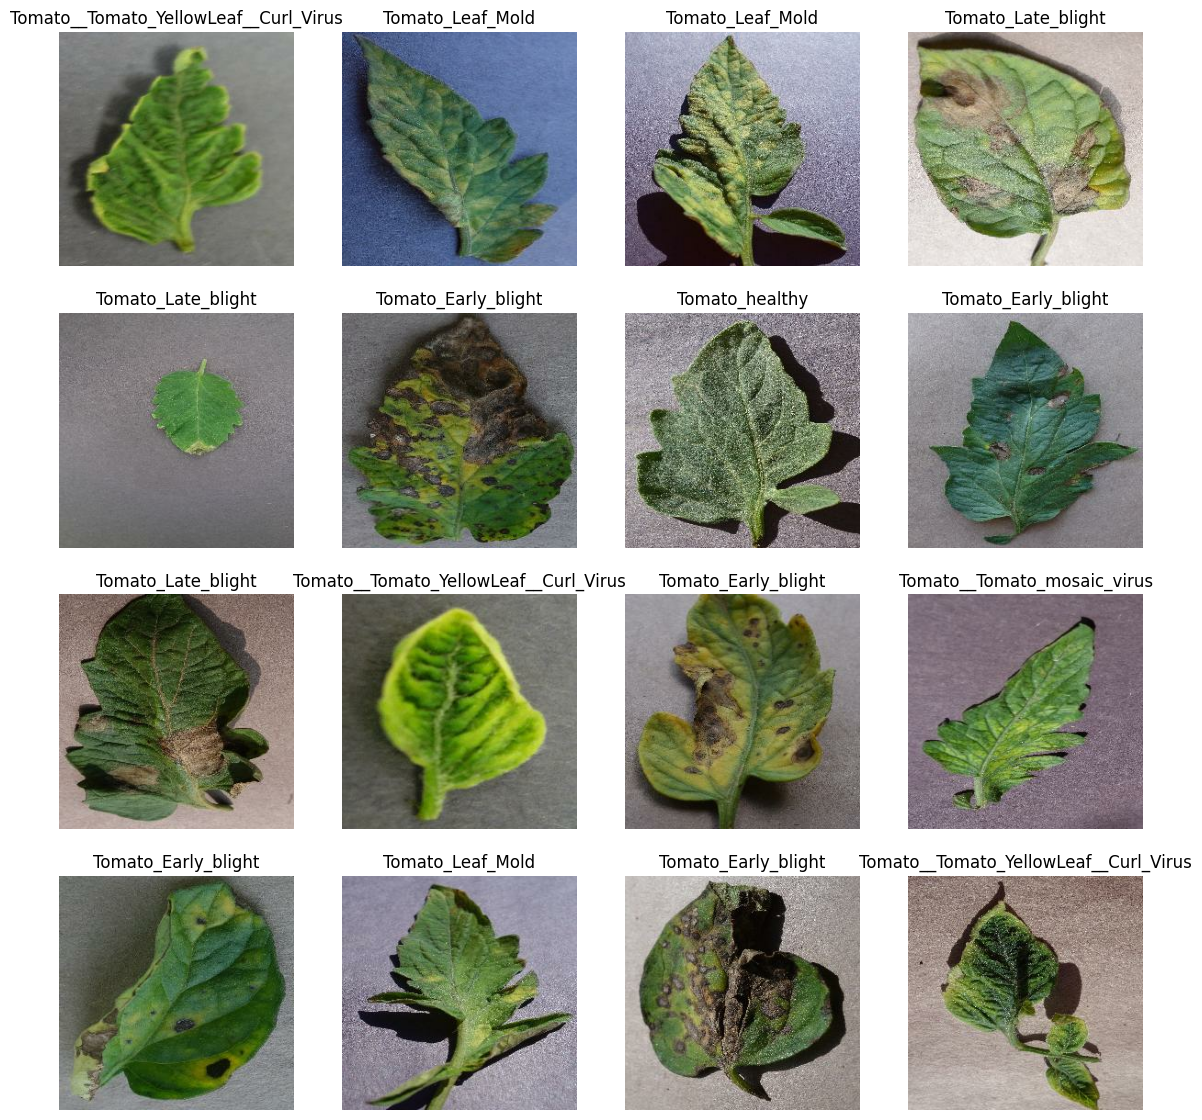

In [13]:
plt.figure(figsize=(14,14))

for img_batch, label_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.title(class_names[label_batch[i]])
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        

In [14]:
def get_ds_partitions(ds, train_size=0.8, val_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_ds = ds.take(int(ds_size*train_size))
    val_ds = ds.skip(int(ds_size*train_size)).take(int(ds_size*val_size))
    test_ds = ds.skip(int(ds_size*train_size)).skip(int(ds_size*val_size))

    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_ds_partitions(dataset)

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


In [24]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [25]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [27]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape = input_shape)

In [28]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (32, 127, 127, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (32, 125, 125, 64)        18496     
                                                      

In [30]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [31]:
model.fit(
    train_ds,
    epochs=EPOCHS,
    verbose=1,
    batch_size=BATCH_SIZE,
    validation_data=val_ds
)

Epoch 1/50


226/226 [==============================] - 214s 839ms/step - loss: 1.0411 - accuracy: 0.5931 - val_loss: 0.6836 - val_accuracy: 0.7679
Epoch 2/50
226/226 [==============================] - 180s 793ms/step - loss: 0.5985 - accuracy: 0.7732 - val_loss: 0.5682 - val_accuracy: 0.8013
Epoch 3/50
226/226 [==============================] - 155s 687ms/step - loss: 0.4521 - accuracy: 0.8358 - val_loss: 0.3735 - val_accuracy: 0.8460
Epoch 4/50
226/226 [==============================] - 246s 1s/step - loss: 0.3820 - accuracy: 0.8609 - val_loss: 0.3539 - val_accuracy: 0.8817
Epoch 5/50
226/226 [==============================] - 585s 3s/step - loss: 0.3580 - accuracy: 0.8686 - val_loss: 0.3637 - val_accuracy: 0.8862
Epoch 6/50
226/226 [==============================] - 132s 586ms/step - loss: 0.2992 - accuracy: 0.8939 - val_loss: 0.4365 - val_accuracy: 0.8605
Epoch 7/50
226/226 [==============================] - 149s 660ms/step - loss: 0.2673 - accuracy: 0.9035 - val_loss: 0.2744 - val

In [32]:
model.evaluate(test_ds)

29/29 [==============================] - 36s 209ms/step - loss: 0.3986 - accuracy: 0.8955


[0.3985787630081177, 0.8954741358757019]

first image to predict
actual label Tomato__Tomato_YellowLeaf__Curl_Virus
1/1 [==============================] - 0s 113ms/step
predicted label: Tomato__Tomato_YellowLeaf__Curl_Virus


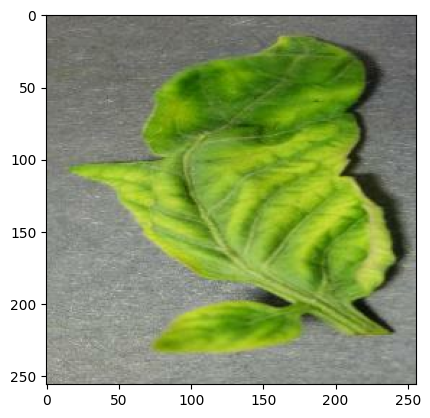

In [45]:
for image_batch, labels_batch in test_ds.take(1):

    first_image = image_batch[1].numpy().astype('uint8')
    first_label = labels_batch[1].numpy()

    print('first image to predict')
    plt.imshow(first_image)
    print("actual label", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print('predicted label:', class_names[np.argmax(batch_prediction[1])])

In [46]:
def predict(model, image):
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]

    confidence = round(100* np.max(predictions[0]), 2)

    return predicted_class, confidence


1/1 [==============================] - 0s 32ms/step


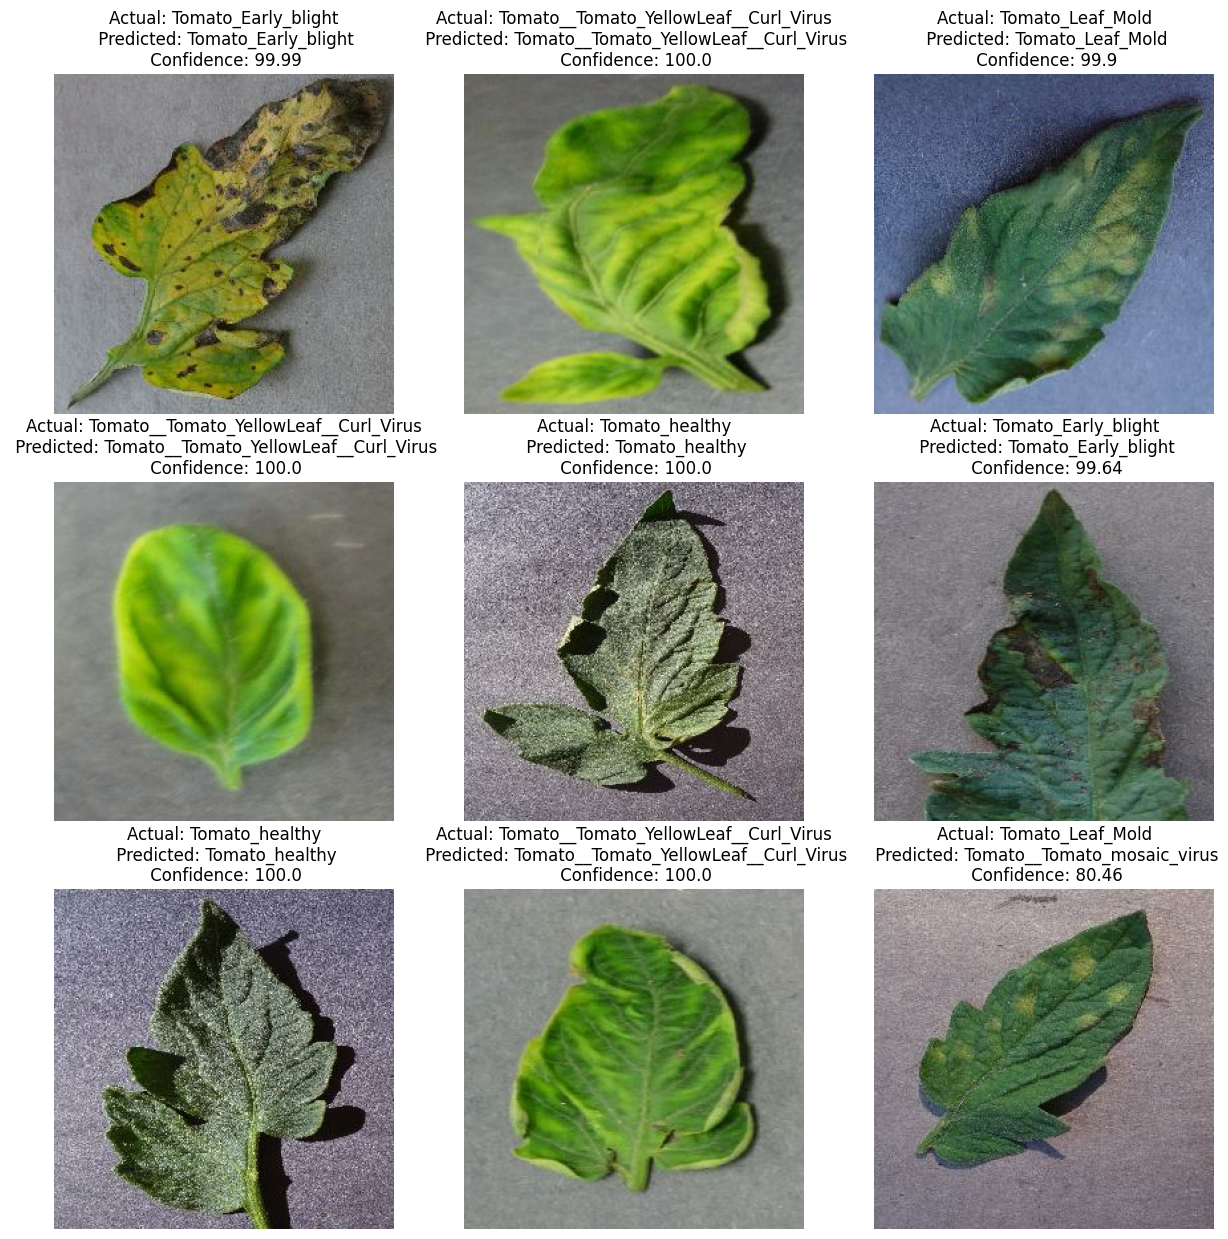

In [48]:
plt.figure(figsize=(15,15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}\n Confidence: {confidence}")


        plt.axis('off')

In [49]:
model_version = 'T1'
model.save(os.path.join('models', model_version))

INFO:tensorflow:Assets written to: models\T1\assets


INFO:tensorflow:Assets written to: models\T1\assets
